# Experiments for the time-dependent problem

In [1]:
import torch.optim as optim
import matplotlib.pyplot as plt
import torch
import numpy as np
from scipy.integrate import solve_ivp
from time import time as t

import sys
# setting path
sys.path.append('../')

from visualization.plots_time_dependent import plot_level_set_time_dependent
from Hamiltonians.time_dependent_LxF import Eikonal_sq_LxF_Euler_explicit
from PointSampling.time_dependent import data_gen_cube_T
from NeuralNetworks.NNs import FCFF_3L, FCFF_4L

#Right-hand-side of the PDE
def f(X):    
    return -.5*(X**2).sum(-1) 

def c(X):
    return .5 


training_params = {
    'numerical_scheme': Eikonal_sq_LxF_Euler_explicit,

    'f': f,
    'c': c,
    
    'beta': 0.,  ## parameter for the +u_i term
    
    'lambda': 1. #weight parameter for the boundary loss
    }

In [2]:
# Dimension of the d-dimensional cube for each experiment
dim_list = 3*[2] # + 3*[5]
# Number of neurons per hidden layer
arch_list = [2*[50], 3*[50], 3*[50]] + [2*[80], 3*[80], 3*[80]]

n_experiments = len(dim_list)
side_length = 6.
T = .5


# Parameters for each experiment
delta_x_list = [[.5, .3, .2, .1]]*n_experiments
delta_t_list = [[.05, .03, .02, .01]]*n_experiments
alpha_list = [[2.5, 2., 1.5, 1.]]*n_experiments
rounds = len(alpha_list[0])

N_col_list = [[100]*rounds]*n_experiments
N_b_list = [[20]*rounds]*n_experiments
num_iterations_list = [[2000]*(rounds-1) + [5000]]*n_experiments   

100%|██████████| 5000/5000 [00:54<00:00, 91.61it/s] 
C:\Users\usuario\anaconda3\envs\FD_PINNs\Lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


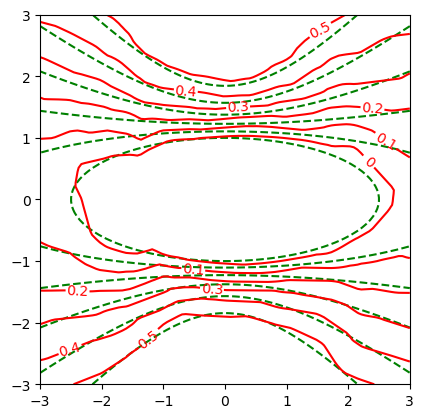

100%|██████████| 5000/5000 [00:57<00:00, 87.55it/s] 


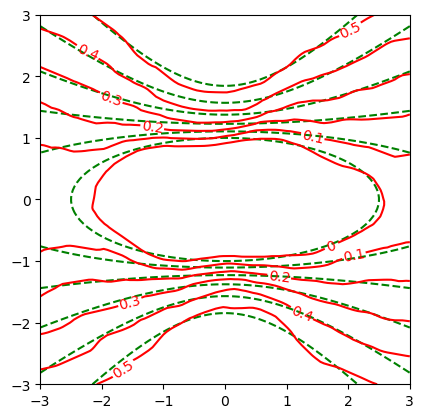

100%|██████████| 5000/5000 [00:45<00:00, 109.91it/s]


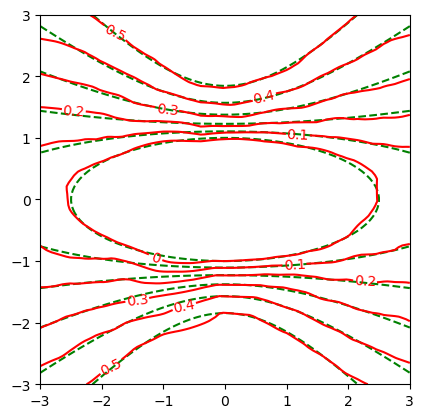

In [3]:
from Training.training import train_time_dependent

R_loss = torch.zeros([n_experiments, rounds])
L_loss = torch.zeros([n_experiments, rounds])
run_times = torch.zeros([n_experiments])


for j in range(n_experiments):

    dim = dim_list[j]
    
    # Initial condition
    a = torch.ones([1,dim])
    a[:,0] = 4/25
    a[:,1] = 1

    def g(X):
        x = X[:, 1:]
        Ax = a*x 
        return .5*((x*Ax).sum(-1) - 1.)

    # Solution to Riccati differential equation
    def Riccati(t, y):
        y = y.reshape(dim, dim)
        return (-np.matmul(y,y) - np.eye(dim)).reshape(-1)
        
    n_t_grid = 6
    t_list = np.linspace(0,T, n_t_grid)
    P0 = np.diag(a[0])
    sol = solve_ivp(Riccati, [0,T], P0.reshape(-1), t_eval = t_list)
    P_t = sol.y.transpose().reshape(-1, dim, dim)

    # Finite-difference PINNs
    domain = data_gen_cube_T(side_length, T, dim_list[j])
    
    training_params['g'] = g
    
    if len(arch_list[j]) == 2:        
        NN = FCFF_3L([dim_list[j]+1] + arch_list[j])
    else:
        NN = FCFF_4L([dim_list[j]+1] + arch_list[j])
    
    training_params['optimizer'] = optim.SGD(NN.parameters(), lr = .005, momentum = .2)
    
    time = 0.
    
    for i in range(rounds):
        
        training_params['alpha'] = alpha_list[j][i]
        training_params['delta x'] = delta_x_list[j][i]
        training_params['delta t'] = delta_t_list[j][i]
        
        training_params['n_coloc_points'] = N_col_list[j][i]
        training_params['n_boundary_points'] = N_b_list[j][i]
        training_params['num_iterations'] = num_iterations_list[j][i]
        
        t0 = t()
        total_loss, PDE_loss, boundary_loss = train_time_dependent(NN, domain, training_params)
        time += t() - t0
        
        R_loss[j,i] = PDE_loss[-20:].mean()
        L_loss[j,i] = boundary_loss[-20:].mean()
        
        #plt.plot(total_loss)
        #plt.title('Total loss')
        #plt.show()
        
        #plt.plot(PDE_loss)
        #plt.plot(boundary_loss)
        #plt.title('R(u) and L(u)')
        #plt.show()
    
    run_times[j] = time
    
    X_axis = 0
    Y_axis = 1

    n_grid = 100
    plot_level_set_time_dependent(X_axis, Y_axis, NN, n_grid, n_t_grid, side_length, T, P_t_Riccati = P_t)
    #print('R(u) =', R_loss[j])
    #print('L(u)=', R_loss[j])   


In [4]:
import pandas as pd
import numpy as np

training_features = pd.DataFrame({'Dimension': dim_list,
                                  'Architecture': arch_list,
                                  'delta x': delta_x_list,
                                  'delta x': delta_x_list,
                                  'alpha': alpha_list,
                                  'N': N_col_list,
                                  'N_b': N_b_list,
                                  'Iterations': num_iterations_list,})
run_T = pd.DataFrame({'Runtime (s)': np.array(run_times)}).round(1)

PDE_loss = pd.DataFrame(np.array(R_loss))
boundary_loss = pd.DataFrame(np.array(L_loss))


#display(training_features.join(PDE_loss).join(run_T).transpose())
#display(training_features.join(boundary_loss).join(run_T).transpose())

# One table
R_loss_final = np.expand_dims(np.array(R_loss[:,-1]), axis = 1)
L_loss_final = np.expand_dims(np.array(L_loss[:,-1]), axis = 1)
losses = np.concatenate((R_loss_final, L_loss_final), axis = 1)
results = pd.DataFrame(losses,  columns = ['R_loss', 'L_loss'])

#display(training_features.join(results).join(run_T).transpose())

ValueError: All arrays must be of the same length